## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [1]:
#!git clone https://github.com/terleckimaciej/neural_nets_training.git
#%cd neural_nets_training/
!git status

fatal: not a git repository (or any of the parent directories): .git


In [2]:

# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2026-01-12 09:52:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2026-01-12 09:52:11 (22.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [5]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


najprostszy encoder - openai uzywa np tiktoken

In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) #pierwszy argument (max_value) - maksymalny indeks
                                                              #od ktorego mozemy zaczac sekwencje czyli dlugosc danych - rozmiar batcha
                                                              #drugi argument (num_samples,) - indeks ile losowych liczb od 0 do max_value
                                                              #wygenerowac. czyli ix bedzie tensorem czterech (batch_size) losowych indeksow
                                                              # od 0 do do max_value = len(data)-batch_size

    x = torch.stack([data[i:i+block_size] for i in ix])       # laczenie sekwencji tensorow wzdluz nowego wymiaru
                                                              # czyli cos jak ulozenie "plaskich" tensorow w stos/stack
                                                              # dla kazdego wylosowanego i indeksu z ix wez sekwencje od tego indeksu do
                                                              # konca naszego rozmiaru batcha

    y = torch.stack([data[i+1:i+block_size+1] for i in ix])   # dla kazdego indeksu i tworzy sekwencje block_size znakow, ktora jest przesunieta
                                                              # czyli nasze cele (targety) do przewidzenia
    return x, y
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [13]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

        #Pomyśl o tym jak o dużej tabeli: W tej tabeli mamy vocab_size wierszy (po jednym dla każdego unikalnego znaku w naszym słowniku).
        #Każdy wiersz ma vocab_size kolumn. Wartości w tych kolumnach to "logity" (czyli surowe, nieskończone "punkty") dla przewidywania następnego znaku.
        #Jak to działa? Kiedy model widzi znak o identyfikatorze X, po prostu "patrzy" na X-ty wiersz tej tabeli.
        #Wiersz ten zawiera vocab_size liczb, gdzie każda liczba mówi, jak prawdopodobne jest, że dany znak ze słownika (0 do vocab_size-1) będzie następnym.
        #To dlatego nn.Embedding ma vocab_size zarówno dla pierwszego, jak i drugiego argumentu –
        #bo wejście to indeks znaku, a wyjście to logity dla wszystkich możliwych następnych znaków.

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers.
        # B-atch, T-ime. idx - tensor wejsciowy, targets - tensor celow
        # sluzy do obliczenia loss-u

        # dla kazdego znaku w idx model szuka w tabeli embeddingu tokenow odpowiadajacego mu wiersza (w ktorym p-bienstwa wystapienia nastepnego znaku)
        # idx ma ksztalt (B, T) wiec logits ma (B, T, C), gdzie C (Chanell) to vocab_size (dlugosc slownika unikalnych tokenow)
        # dla kazdej sekwencji znakow i dla kazdego znaku w tej sekwencji mamy vocab_size liczb mowiacych jak prawdopodobny jest kazdy mozliwy nastepny znak
        logits = self.token_embedding_table(idx) # (B,T,C)

        #jesli nie podalismy targets czyli np. chcielismy tylko wygenerowac tekst, nie trenowac model, nie liczmy straty
        if targets is None:
            loss = None
        else:
          #rozpakowujemy ksztalt logits (embedding) na batch size, time i vocab_size
            B, T, C = logits.shape
            #techniczna podmianka ksztaltu, bo pozniej funkcja F.cross_enropy (loss) oczekuje jednego argumentu, wiec laczymy wymiary batch i time w jeden dlugi
            # przez to z (4, 8, 65) robi sie (32, 65) czyli mamy 32 niezalezne przeiwdywania, gdzie kazde ma 65 mozliwych znakow
            logits = logits.view(B*T, C)
            # targets tez zmieniamy tak, aby pasowaly do logits - z (4, 8) robi sie (32). teraz mamy 32 odpowiedzi (id znakow) dla kazdego przewidywania
            targets = targets.view(B*T)
            #obliczamy loss
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # pozwala modelowi "pisac" nowy tekst. potrzebuje poczatkowego idx - pierwszego znaku, od ktorego zacznie i max_new_tokens - ile ma znakow wygenerowac
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens): #generowanie jednego znaku, az nie bedzie ich max_new_tokens
            # get the predictions - wykonanie kroku forward na idx, nie dajemy targets wiec loss bedzie None
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C). bierzemy tylko logit z ostatniego znaku biezacego kontekstu - bo tylko ten jest nam potrzebny
                                      # do przewidzenia nastepnego znaku (ktorego jeszcze nie ma)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C) - przeksztalcenie surowe logity (dowolne liczby) w takie  z zakresu 0-1, ktore sumuja sie do 1.
                                              # dzieki temu sa interpretowalne jako pradopodobienstwo
            # sample from the distribution - branie "losowo" nastepnego znaku. losowo, ale z wagami prawdopodobienstwa obliczonymi wczesniej -
            # im wyzsze pd-bienstwo tym czesciej dany znak bedzie sie losowal, ale bedzie roznorodnosc odpowiedzi, nie zawsze to samo
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
                              # tutaj jest zero do inicjalizacji 1x1 z zerem. ma to sens zwlaszcza w tym przypadku, bo 0 oznacza w naszym decodingu poczatek nowej
                              # linii. przy innym encodowaniu trzeba bedzie zwrocic na to uwage, byc moze jakos zastapic, na pewno rozwazyc
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


na razie powyzej mamy model bigramowy, po pierwwsze totalnei losowe przewidywanie (stad taki zd upy string) - nie bylo jeszcze treningu dla uzyskania embeddigow sensownych, po drugie bigram patrzy tylko na jeden znak przed tym, ktory ma przewidziec, wiec na razie nie spelnia on funkcji przewidywania na podstawie calego kontekstu tego, co bylo wczesniej - jest to zatem praktycznie tylko demonstracja najprostszego mozliwego wariantu, ktory dziala


In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [16]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.382369041442871


koniec konwergencji jakos na 2.4 - zeszlismy z 4,6

In [17]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


## The mathematical trick in self-attention

In [18]:
a = torch.tril(torch.ones(3, 3))
a1 = torch.sum(a, 1, keepdim=True)
a2 = a / torch.sum(a, 1, keepdim=True)
print(a)
print(a1)
print(a2)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
tensor([[1.],
        [2.],
        [3.]])
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])


teraz sprobujemy uwzglednic wszystkie poprzedzajace przewidywany token tokeny dla danego batch'a - na razie w formie brania po prostu obsranej sredniej z prawdopodobienstw wszystkich wczesniejszych tokenow

In [19]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
#czyli w jaki sposob możemy uzyskać ważoną agregację, a zatem średnią kumulatywnej
# tak działają mechanizmy uwagi w transformerach - możemy w ten sposób uśredniać embeddingi
# z poprzednich tokenów
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) #macierz z jedynkami przekształcona by elementy
                                  # powyżej przekątnej się wyzerowały
a = a / torch.sum(a, 1, keepdim=True) #sumowanie elementy każdego wiersza macierzy a
                                      # keepdim - wymiar pozostaje (3 kol)
                                      # dzielimy a przez nią i znormalizowalismy by
                                      # wiersze dodawały się do 1. rozłożyłem to
                                      # w następnej komórce. mamy teraz "macierz wag"
                                      # niezbędną do policzenia średniej kumulatywnej
                                      #każdy kolejny wiersz ma wage rozłożoną na kolejną komórkę - odpowiada za kolejny token
b = torch.randint(0,10,(3,2)).float() #losowe liczby całkowite - symulacja danych wejściowych - 3 el w sekwencji i 2 chanelle (cechy)
c = a @ b # operator mnożenia macierzy torcha. mnożymy dane wejściowe przez  - efektem jest obliczenie wagi kumulatywnej
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [20]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C) #wypełnienie tensora losowymi liczbami z rozkł. norm (0,1)
x.shape

torch.Size([4, 8, 2])

In [21]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) # xbow - Bag of Words - average'owanie rzeczy, mamy worek slow.
                            # inicjujemy zerami. Posłuży do przechowania wyników  obliczeń
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C) - dla bieżącego batcha bierzemy wszytkie elementy do początku
                          # do t (trzeb zrobić t+1 w pythonie)
        xbow[b,t] = torch.mean(xprev, 0) #średnia wzdłuż kanału 0 (czyli dla każdego kanału C)
                                         # wynik średniej (wektor o rozmiarze C) jest przypisywany
                                         # do odpowiedniej pozycjji xbow[b, t]
                                         # b i t do indeksy, ktore wskazuja konkretnie miejsce
                                          #  w tensorze xbow, do którego chcemy przypisać wartosc
                                          #  xbow bowiem to tensor o wymiarach (B, T, C), nie żadna
                                          #  np funkcja z argumentami


In [22]:
x[0], xbow[0]
#pierwszy wiersze drugiej tabeli jest taki sam jak pierwszej - jest to jego srednia
# drugi wiersz drugiej tabeli jest inny - jest średnią dwóch pierwszych wierszy pierwszej tabli
# itd

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

In [23]:
# version 2: using matrix multiply for a weighted aggregation
# weights
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True) #nasz wektor wag
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C) #mnożenie wejścia przez wagi
torch.allclose(xbow, xbow2) #sprawdzenie czy tensory są take same (z tolerancją na różnice międzyprzecinkowe wynikające z dzielenia).

False

wyszło false, choć powinno True - teoretycznie jest tolerancja na liczby po przecinku... no ale organoleptycznie wygląda tak samo :/

In [24]:
# print('xbow:', xbow)
# print('xbow2:', xbow2)

In [25]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T)) #same zera - inicjalizacja
wei = wei.masked_fill(tril == 0, float('-inf')) # wszędzie gdzie są zera wstaw -∞ (-nieskończoność)
# to nam mówi, że: tokeny z przeszłości nie mogą komunikowac się z tokenami z przyszłości
#dzięki zaminieniu zer na -∞, softmax nie traktuje tych wartości jako normalnej liczby (jak 0), więc nie nadaje jej wagi
# softmax myśli: dodatnia liczba - ważne, ujemna - mało ważne, 0 - średnio ważne. A ma myśleć 0 - nie wolno. Inaczej przyszłość
# dostanie zarówno wagę jak i gradient. Matematycznie softmax robi: exp(0)=1 (waga 1), a exp(=∞)=0 (waga 0). -∞ to sposób powiedzenia softmaxowi
# , ze ta waga nie istnieje i ma ją olać

wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

False

In [26]:
print('wei:\n', wei)
print('\nxbow3:\n', xbow3)

wei:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

xbow3:
 tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.

Uzyskaliśmy zatem równomiernie rozłożone wagi poprzednich tokenów (względem przewidywanego). Ich równomierne rozłożenie wynikało z tego, że zainicjowaliśmy je przez zera - teraz chcemy, aby inichalne wagi były dynamicznie obliczone na podstawie danych wejsciowych.

# mechanizm self attention - problematyka
Problem, którego rozwiązaniem jest mechanizm self-attention polega na dynamicznym, kontekstowym wyborze informacji w sekwencji. Zatem w naszym przypadku polega na wyborze "ważności" każdego z sekwencji tokenów poprzedzającej ten przez nas przewidywany. Ma ona zależeć od aktualnego tokena i kontekstu, a nie od pozycji, czy jakiejś stałej reguły.



# niewystarczalność poprzednich podejść:
np. bigramy, n-gramy - kontekst o odgórnej ustalonej długości, brak hierarchi znaczeń, brak uogolnienia


inne modele Dl, np. sekwencyjne (RNN - recurrent neural networks i jego rozwinięcia jak LSTM i GRU) - mają bottlenecka - jeden wektor stanu, który potrzebuje wyniku dla t-1 - informacja z dalszego kontekstu musi "przetrwać" wiele kroków, w których słabnie gradient, a więc jej znaczenie. Uniemożliwia oczywiście tez jednoczesne przetwarzanie wag. Metaforycznie "spróbuj streścić cały akapit do jednego zdania, a następnie odpowiadać na pytania dotyczące akapitu tylko na podstawie znajomości tegoż streszczenia". W self-attention nie mamy takiej rekurencji, możemy przetwarzać równolegle. Wszystko w jednym forward passie się dzieje, równolegle.


W CNN (Convolutional Neural Nets) problemem jest lokalne okno kontekstu, stała jego geometria, brak globalnego, selektywnego dostępu, który jest potrzebny do przetwarzania języka naturalnego (podmiot i orzeczenie mogą być daleko, nawet nie w jednym zdaniu.


Self attention eliminuje konieczność spłaszczania kontekstu do stanu i zastępuje ją bezpośrenim, ważonym dostępem do całej historii.
-brak wąskiego gadła stanu
-równoległość przetwarzania (GPU może rozwinąć skrzydła)
-koszt zależności od odległego tokena nie rośnie wraz z jego odległością (modele sekwencyjne)
Zamiast pamięci (uwaga jak u człowieka) tworzy się coś w rodzaju bazy danych  dynamicznym zapytaniem, gdzie każde zapytanie (następny przwidywany token) ma inne kryterium podobieństwa (implikowany jego wartością). Każdy token selektywnie agreguje sobie informacje z całej historii embeddingów poprzednich tokenów

każdy token wyemituje 2 wektory:
-query
-key,
gdzie query to mniej więcej "what am i looking for?", a key "what do I contain?". Z tych dwóch wektorów brany jest iloczyn skalarny, który dla każdego tokena poprzedzającego token procesowany (przewidywany w następnej kolejności) mówi nam, jak bardzo nasz token "interesuje się" tym konkretnym poprzednim tokenem - czyli nadaje wagę bliskości/więzi tych dwóch tokenów.

W ten sposób uzyskujemy początkowe wagi, które wcześniej inicjowaliśmy jako zera - surowe wyniki dopasowania, które następnie znormalizujemy naszym Softmaxem. Wszystko dzieje się jeszcze przed rozpoczęsciem komunikacji między tokenami - dzięki temu, możemy ją następnie zainicjować przetwarzając równolegle.  

In [27]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C) #tworzenie

# let's see a single Head perform self-attention
head_size = 16 # hiperparametr - jedna głowa = jedna instancja mechanizmu self attention, jak poniżej. patrzy ona na 16-wymiarową projekcję tokenów
               # normanie będziemy mieli wiele głów - każda liczy swoje wagi, widzi inne zależności (np. jedna patrzy na zgodność gramatyczną,
               # inna na relację sematyczną, a inna na struktury dialogu), tutaj dla prostoty zostańmy przy jednej

key = nn.Linear(C, head_size, bias=False) # tworzymy warstwę liniową (bardzo prosta NN bez aktywacji), która będzie przekształać wejście x (o wymiarze C)
                                          # w wektory kluczy (k) o wymiarze . Opisują one każdy token - co on zawiera - coś jak indeks
query = nn.Linear(C, head_size, bias=False) #podobnie, tu przekształcamy x w wektory zapytań do poszukiwania informacji
value = nn.Linear(C, head_size, bias=False) # tu przekształcamy to w wektor wartości - rzeczywistą informację, do wyodrębnienia i zagregowania
                                            # gdy klucz odpasuje się do zapytania

k = key(x)   # (B, T, 16) | wpuszaczamy wejścioweembeddingi w tensory: kluczy,
q = query(x) # (B, T, 16) | i zapytań
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T) | obliczamy surowe wyniki uwagi (wcześniej inicjowane jako zera) poprzez mnożenie
                               # macierzowe. Transpozycja zamienia miejscami T z head_size (tu 16), bo jest potrzebne do przemnożenia macierzy
                               # Iloczyn skalarny daje nam "wynik dopasowania" (affinity) między tokenem aktualnym i każdym go poprzedzającym

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) # normalizacja jw. , ma patrzeć tylko na siebie i to co było wcześniej , a wynikowe wagi mają być >=0 i sumowac się do 1 (softmax)

v = value(x) # przekształcenie x w tensory wartości
out = wei @ v # teraz wyjście wartości mnożone jest przez macierz wag inicjalnych. Dla każdego tokena out to ważona suma wektorów wartości wszystkich
              # porzednich tokenów
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention",
the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

Poniżej przedstawione jest zastosowanie ostatniej uwagi z powyższego. W paperze "Attention is all you need" zdefiniowano uwagę następująco:

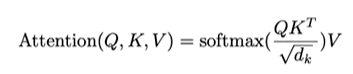

Ten pierwiastek pozwala uniknąć "rozlania się" wag po zaaplikowaniu softmaxa. Wagi będą przez to nieproporcjonalnie "dryfujące", jak niżej:

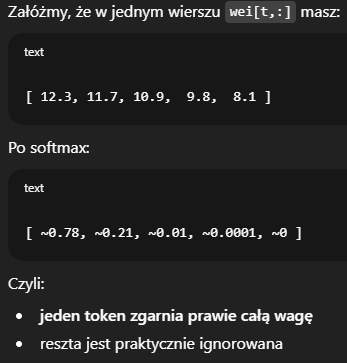

Po podzieleniu przez √(head_size) wariancja sum embeddingów jest równa 1, a nie wielkości głowy, dzięki czemu np.

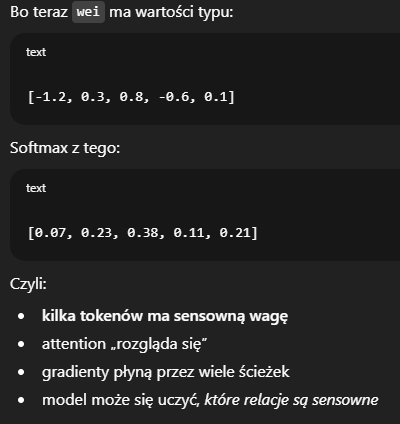

Dlatego scaled dot-product attention to: czysto numeryczny zabieg stabilizacyjny analogiczny do:
inicjalizacji wag,
normalizacji,
layernorm

In [28]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [29]:
k.var()

tensor(1.0449)

In [30]:
q.var()

tensor(1.0700)

In [31]:
wei.var()

tensor(1.0918)

In [32]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


FileNotFoundError: [Errno 2] No such file or directory: 'input.txt'